# 下载和缓存数据集

- 字典DATA_HUB 
  - 将数据集名称映射到其相关的二元组上
  - 二元组包含这个数据集的url和验证文件完整性的sha-1密钥
- 所有类似的数据集都托管在地址为DATA_URL的站点上。

In [319]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

- 下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 
- 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [320]:
def download(name,cache_dir = os.path.join('..','data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB ,f"{name} 不存在于{DATA_HUB}"
    url ,sha1_hash = DATA_HUB[name]
    # 创建目录cache_dir，允许已存在
    os.makedirs(cache_dir,exist_ok=True)
    # cache_dir和url中获取的组成完整路径名
    fname = os.path.join(cache_dir,url.split('/')[-1])
    # 如果有缓存，就校验缓存，不用下载
    if os.path.exists(fname):
        # 创建一个sha1的对象
        sha1 = hashlib.sha1()
        with open(fname,'rb') as f :
            while True:
                # 分块读取文件，一次读1MB=1048576 byte
                data = f.read(1048576)
                if not data:
                    break
                # 加入sha1对象
                sha1.update(data)
        # 计算hash值，转为十六进制后对比
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    # 缓存中没有则下载
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

- 再实现两个实用函数： 
  - 一个将下载并解压缩一个zip或tar文件， 
  - 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [321]:
def download_extract(name,folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    # os.path.splitext分割出后缀名
    data_dir , ext==os.path.splitext(fname)
    if ext =='.zip':
        fp = zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp = tarfile.open(fname,'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extarctall(base_dir)
    # 返回路径：当前路径+文件目录
    return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)


# 访问和读取数据集

In [322]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

- 为了方便，可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。

In [323]:
DATA_HUB['kaggle_house_train']=(
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test']=(
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')


- 用pandas分别加载包含训练数据和测试数据的两个csv文件

In [324]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [325]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


- 看看前四个和最后两个特征，以及相应标签（房价）

In [326]:
# iloc,两个参数分别表示行和列
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


- 可以看到每个样本中，第一个特征是id，这有助于模型识别每个训练样本
  - 虽然这很方便，但它不携带任何用于预测的信息
  - 因此再将数据提供给模型之前
  - 把id从数据集中删除

In [327]:
# 用iloc选中所有行，和第二列以后的数据即可删除
# 用concat把训练和测试放到一起，方便后面划分k折
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

# 数据预处理
- 因为如上我们有各种各样的数据类型，所以要数据预处理
  1. 将所有确实的值替换成相应特征的平均值
  2. 为了将所有特征放在一个共同的尺度上
      - 我们通过将特征重新缩放到零均值和单位方差来标准化数据:
      - $x \leftarrow \frac{x - \mu}{\sigma},$
      - 其中$\mu$和$\sigma$分别表示均值和标准差。
- 现在，这些特征具有零均值和单位方差
  - 即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
  - $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
- 直观地说，我们标准化数据有两个原因：
  - 首先，它方便优化。
  - 其次，因为我们不知道哪些特征是相关的，  
- 所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [328]:
# 若无法获得测试数据，则课根据训练数据计算均值和标准差
# 获取数值类型的特征的索引，不是object即数值
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
# 对数值类型的特征标准化处理
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())
)
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features]=all_features[numeric_features].fillna(0)

- 处理离散值
  - 独热编码来替换他们
    - 所以处理后特征维度会变很大，但没关系
  - pandas的`pd.get_dummies()`会自动实现one-hot

In [329]:
s = pd.Series(list('abca'))
s1 = ['a', 'b', np.nan]
s,s1

(0    a
 1    b
 2    c
 3    a
 dtype: object,
 ['a', 'b', nan])

In [330]:
pd.get_dummies(s)

,a,b,c
0,True,False,False
1,False,True,False
2,False,False,True
3,True,False,False


In [331]:
pd.get_dummies(s1)

,a,b
0,True,False
1,False,True
2,False,False


In [332]:
pd.get_dummies(s1,dummy_na=True)

,a,b,NaN
0,True,False,False
1,False,True,False
2,False,False,True


In [333]:
# "Dummy_na=True" 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

- 可以看到此转换会将特征的总数量从79个增加到331个。
- 最后，通过`values`属性，
  - 我们可以
[**从`pandas`格式中提取NumPy格式，并将其转换为张量表示**]用于训练。

In [334]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32),dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32),dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32
)

# 训练
- 首先，我们训练一个带有损失平方的线性模型。 
  - 线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。
  - 显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查， 以查看数据中是否存在有意义的信息。
  -  如果我们在这里不能做得比**随机猜测**更好，那么我们很可能存在数据处理错误。 

In [335]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

### 我们更关心相对误差而不是绝对误差

- [**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
- 而不是绝对误差$y - \hat{y}$。
- 例如，贵的房子变动5000和便宜的房子变动5000的效果是不一样的

#### 解决这个问题的一种方法是用价格预测的**对数**来衡量差异
- 事实上，这也是比赛中官方用来评价提交质量的误差指标。
- 即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
- 转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
- 这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

- $$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$
- 相对误差可以变化为，$1-\frac{\hat{y}}{y}$
  - 前面的1-去哪里了？

In [336]:
def log_rmse(net,features,labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1,限制预测值在1~∞之间,不让取对数出错（取到负值）
    # torch.clamp，裁剪，裁剪预测值，限定在1~∞
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    # .item()将tensor张量转为标量
    return rmse.item()

- 用Adam优化器
  - 自适应

In [337]:
def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls, test_ls =[],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    # Adam
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            # 训练网络用的损失不还是MSELoss
            # 那关注的不还是绝对误差？
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        # 保存每个epoch的损失值，方便后续可视化
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls


- 上面训练还是用的MSELoss损失来优化网络，关注的是绝对误差
- `train_ls`记录的是log_rmse,取了log的损失，关注的是相对误差
  - 因为后面k折，对比每折的log_rmse损失来调整模型。所以也变相是关注相对误差了吧。
  - 论坛的回答：
    - 跟之前准确率一样,只是方便人的观察,训练还是用之前的
    - 预测问题在训练时还是使用最小均方误差作为损失函数，定义的log_rmse只是用来比较不同模型的好坏
    - 我觉得是log rmse里面会对数据做截断，没法求导。

# K折交叉验证
- 它有助于模型选择和超参数调整
- 我们首先需要定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。
  - 具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。
  - 注意，这**并不是处理数据的最有效方法**，如果我们的数据集**大得多**，会有其他解决办法。

In [338]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0]//k # 每折的大小
    X_train, y_train = None,None
    # 循环k次，对每折分别做处理
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size) # 第j折的索引切片
        X_part,y_part = X[idx,:],y[idx]
        # i是验证集的折数
        if j == i:
            X_valid,y_valid = X_part , y_part
        elif X_train is None: # 第一次
            X_train,y_train = X_part , y_part
        else: # 拼接上前面的就好
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    # 返回训练集和验证集
    return X_train, y_train , X_valid , y_valid


- 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值

In [339]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,
           batch_size):
    train_l_sum,valid_l_sum = 0,0
    # k折，重复k次
    for i in range(k):
        # 本次的数据
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,
                                  weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],
                     xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                     legend=['train','valid'],yscale='log')
        print(f'折{i+1},训练log rmse{float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum/k,valid_l_sum/k
        

# 模型选择->调参

折1,训练log rmse0.132868,验证log rmse0.142856
折2,训练log rmse0.130163,验证log rmse0.147070
折3,训练log rmse0.129143,验证log rmse0.143321
折4,训练log rmse0.133988,验证log rmse0.135459
折5,训练log rmse0.127223,验证log rmse0.166647
5-折验证：平均训练log rmse：0.130677,平均验证log rmse:0.147071


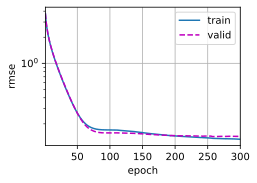

In [340]:
k,num_epochs,lr,weight_decay,batch_size=5,300,5,0.01,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f"{k}-折验证：平均训练log rmse：{float(train_l):f},"
      f"平均验证log rmse:{float(valid_l):f}")

- **请注意**，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多，
- 这表明模型过拟合了。
- 在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。
- 较少的过拟合可能表明**现有数据可以支撑一个更强大的模型**，
- 较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  [**提交Kaggle预测**]

- 既然我们知道应该选择什么样的超参数，
- 我们不妨使用所有数据对其进行训练
  - （而不是仅使用交叉验证中使用的$1-1/K$的数据）。
- 然后，我们通过这种方式获得的模型可以应用于测试集。
- 将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

In [341]:
def train_and_pred(train_features,test_features,train_labels,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_ = train(net,train_features,train_labels,None,None,
                       num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',
             ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
    print(f'训练log rmse:{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    # detach方法用于从计算图中分离出该张量，即不再跟踪其梯度信息。因为我们这里不用反向传播
    # numpy方法将张量转换为NumPy数组。这是因为在后续的处理和导出过程中，使用NumPy数组更加方便和灵活
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    # preds.reshape(1,-1)[0]将数据展平为1维向量，并且取这一行，即取全部
    # pd.Series将向量转为series对象
    # test_data是一个DataFrame对象，每列都是一个Series对象
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    # 将'Id'列和对应的预测结果'SalePrice'列组合起来
    # 组合成一个新的DataFrame对象submission。
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    # index=False表示不将DataFrame的索引列写入CSV文件中。默认true
    submission.to_csv('submission.csv',index=False)

- 如果测试集上的预测与$K$倍交叉验证过程中的预测相似，
- 那就是时候把它们上传到Kaggle了。
- 下面的代码将生成一个名为`submission.csv`的文件。

训练log rmse:0.128439


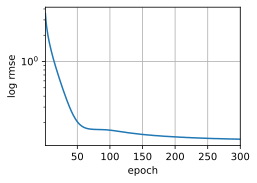

In [342]:
train_and_pred(train_features,test_features,train_labels,test_data,
               num_epochs,lr,weight_decay,batch_size)